In [2]:
import os
import json
from dotenv import load_dotenv
import getpass
from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.tools import tool
from langchain_core.output_parsers import JsonOutputParser
from langchain_openai import ChatOpenAI
from langchain_ibm import WatsonxLLM
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from ibm_watsonx_ai.foundation_models.utils.enums import DecodingMethods
from langchain.prompts import PromptTemplate
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain_core.messages import ToolMessage
from googlesearch import search
import requests
from bs4 import BeautifulSoup

# Environment setup
def _set_env(var: str):
    load_dotenv()  # Load environment variables from .env file
    env_var = os.getenv(var)
    if not env_var:
        env_var = getpass.getpass(f"{var}: ")
        os.environ[var] = env_var
    return env_var

api_key = _set_env("WATSONX_API_KEY")
project_id = _set_env("PROJECT_ID")
url = "https://us-south.ml.cloud.ibm.com"

# Tool definition
@tool
def websearch(query, num_results=10):
    """
    Perform a web search for the given query, retrieve descriptions and first paragraphs
    from the results, and print them in a readable format. Also, append all descriptions
    into a single string and print it.

    Args:
        query (str): The search query.
        num_results (int): The number of search results to retrieve. Default is 10.

    Returns:
        None
    """    
    all_descriptions = ""
    results_data = []
    results = search(query, num_results=num_results)

    for url in results:
        try:
            response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
            response.raise_for_status()
            soup = BeautifulSoup(response.content, 'html.parser')
            meta_description = soup.find('meta', attrs={'name': 'description'})
            description_content = meta_description['content'].strip() if meta_description else 'No description available.'
            first_paragraph = soup.find('p')
            first_sentence = first_paragraph.text.strip()[:500] if first_paragraph else 'No paragraph available.'
            all_descriptions += description_content + "\n"
            results_data.append({
                'url': url,
                'description': description_content,
            })
        except requests.RequestException as e:
            print(f"Failed to retrieve {url}: {e}")
        except Exception as e:
            print(f"An error occurred while processing {url}: {e}")

    return all_descriptions

# WatsonxLLM initialization
parameters = {
    GenParams.DECODING_METHOD: DecodingMethods.SAMPLE.value,
    GenParams.MAX_NEW_TOKENS: 500,
    GenParams.MIN_NEW_TOKENS: 50,
    GenParams.TEMPERATURE: 0.7,
    GenParams.TOP_K: 50,
    GenParams.TOP_P: 1
}
model_id = "ibm/granite-13b-instruct-v2"
watsonx_llm = WatsonxLLM(
    model_id=model_id,
    url=url,
    apikey=api_key,
    project_id=project_id,
    params=parameters
)
template = "You are a chatbot you should answer this question {question} and summarize the following websearch results: {result_websearch}. Answer:"
prompt = PromptTemplate.from_template(template)

# State and Graph definitions
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

class BasicToolNode:
    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

# Creating and adding nodes to the graph
tool_node = BasicToolNode(tools=[websearch])
graph_builder.add_node("tools", tool_node)

# Define the chain
chain = websearch | (lambda result: prompt.format(question=question, result_websearch=result)) | watsonx_llm

# Example usage with LangChain chain
question = "Who is Ruslan Magana"
result = chain.invoke(question)
print("Answer:\n", result)


Answer:
 Ruslan Magana Vsevolodovna, PhD is a Data Scientist and Data Engineer at IBM, a physicist, data scientist, and machine learning engineer with a Ph.D. in physics. He has a certification in Watsonx.data Technical Sales Intermediate from IBM.


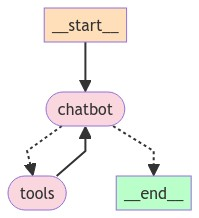

In [11]:
import os
import json
from dotenv import load_dotenv
import getpass
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langchain_core.tools import tool
from langchain_core.output_parsers import JsonOutputParser
from langchain_openai import ChatOpenAI
from langchain_ibm import WatsonxLLM
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from ibm_watsonx_ai.foundation_models.utils.enums import DecodingMethods
from langchain.prompts import PromptTemplate
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain_core.messages import ToolMessage, BaseMessage, HumanMessage
from googlesearch import search
import requests
from bs4 import BeautifulSoup
from IPython.display import Image, display

# Environment setup
def _set_env(var: str):
    load_dotenv()  # Load environment variables from .env file
    env_var = os.getenv(var)
    if not env_var:
        env_var = getpass.getpass(f"{var}: ")
        os.environ[var] = env_var
    return env_var

api_key = _set_env("WATSONX_API_KEY")
project_id = _set_env("PROJECT_ID")
url = "https://us-south.ml.cloud.ibm.com"

# Tool definition
@tool
def websearch(query: str, num_results: int = 10) -> dict:
    """
    Perform a web search for the given query, retrieve descriptions and first paragraphs
    from the results, and print them in a readable format. Also, append all descriptions
    into a single string and print it.

    Args:
        query (str): The search query.
        num_results (int): The number of search results to retrieve. Default is 10.

    Returns:
        None    
     """    

    all_descriptions = ""
    results_data = []
    results = search(query, num_results=num_results)

    for url in results:
        try:
            response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
            response.raise_for_status()
            soup = BeautifulSoup(response.content, 'html.parser')
            meta_description = soup.find('meta', attrs={'name': 'description'})
            description_content = meta_description['content'].strip() if meta_description else 'No description available.'
            first_paragraph = soup.find('p')
            first_sentence = first_paragraph.text.strip()[:500] if first_paragraph else 'No paragraph available.'
            all_descriptions += description_content + "\n"
            results_data.append({
                'url': url,
                'description': description_content,
            })
        except requests.RequestException as e:
            print(f"Failed to retrieve {url}: {e}")
        except Exception as e:
            print(f"An error occurred while processing {url}: {e}")

    return {"descriptions": all_descriptions, "results": results_data}

# WatsonxLLM initialization
parameters = {
    GenParams.DECODING_METHOD: DecodingMethods.SAMPLE.value,
    GenParams.MAX_NEW_TOKENS: 500,
    GenParams.MIN_NEW_TOKENS: 50,
    GenParams.TEMPERATURE: 0.7,
    GenParams.TOP_K: 50,
    GenParams.TOP_P: 1
}
model_id = "ibm/granite-13b-instruct-v2"
watsonx_llm = WatsonxLLM(
    model_id=model_id,
    url=url,
    apikey=api_key,
    project_id=project_id,
    params=parameters
)
template = "You are a chatbot you should answer this question {question} and summarize the following websearch results: {result_websearch}. Answer:"
prompt = PromptTemplate.from_template(template)

# State and Graph definitions
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

class BasicToolNode:
    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

# Function to route based on tool calls
def route_tools(state: State) -> Literal["tools", "__end__"]:
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"

# Chatbot function
def chatbot(state: State):
    last_message_content = state["messages"][-1].content
    result = chain.invoke({"question": last_message_content, "result_websearch": ""})
    return {"messages": [{"type": "assistant", "content": result}]}

# Define the chain
chain = websearch | (lambda result: prompt.format(question=question, result_websearch=result)) | watsonx_llm

# Creating and adding nodes to the graph
graph_builder.add_node("chatbot", chatbot)
tool_node = BasicToolNode(tools=[websearch])
graph_builder.add_node("tools", tool_node)

# Adding conditional edges to the graph
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    {"tools": "tools", "__end__": "__end__"},
)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

# Compiling the graph
graph = graph_builder.compile()

# Plot the Nodes
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Plotting graph failed: {e}")


In [ ]:
# Example use of the graphs
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [{"type": "user", "content": user_input}]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)